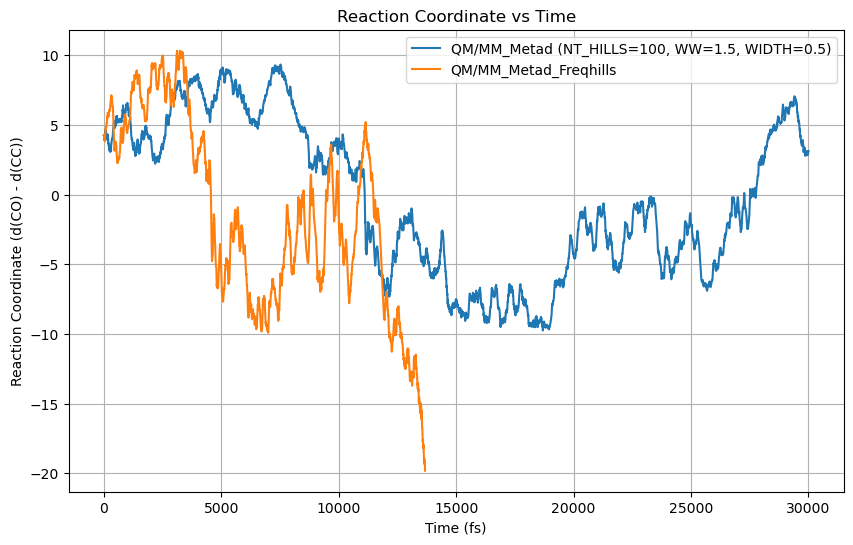

Reaction coordinate plot saved to: ../Figures/Part4_reaction_coordinate_vs_time.png


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Create Figures directory if not exists
os.makedirs("../Figures", exist_ok=True)

# Step 1: Load reaction coordinate data from Outputs/metad1_initmonitor
def load_metadyn_colvar(file_path):
    # Load first two columns: Time (fs) and Reaction Coordinate
    return pd.read_csv(file_path, delim_whitespace=True, header=None, usecols=[0, 1], names=["Time_fs", "Reaction_Coordinate"])

# Load data for standard and freqhills simulations
metadyn_colvar_path_initmonitor = "../Outputs/metad1_initmonitor/METADYN-COLVAR.metadynLog"
metadyn_colvar_path_freqhills = "../Outputs/metad1_initmonitor_freqhills/METADYN-COLVAR.metadynLog"

colvar_data_initmonitor = load_metadyn_colvar(metadyn_colvar_path_initmonitor)
colvar_data_freqhills = load_metadyn_colvar(metadyn_colvar_path_freqhills)

# Step 2: Plot Reaction Coordinate vs Time
plt.figure(figsize=(10, 6))
plt.plot(colvar_data_initmonitor["Time_fs"], colvar_data_initmonitor["Reaction_Coordinate"], label="QM/MM_Metad (NT_HILLS=100, WW=1.5, WIDTH=0.5)")
plt.plot(colvar_data_freqhills["Time_fs"], colvar_data_freqhills["Reaction_Coordinate"], label="QM/MM_Metad_Freqhills")

plt.title("Reaction Coordinate vs Time")
plt.xlabel("Time (fs)")
plt.ylabel("Reaction Coordinate (d(CO) - d(CC))")
plt.legend()
plt.grid(True)

reaction_coordinate_plot_path = "../Figures/Part4_reaction_coordinate_vs_time.png"
plt.savefig(reaction_coordinate_plot_path)
plt.show()

print(f"Reaction coordinate plot saved to: {reaction_coordinate_plot_path}")


In [3]:
import gzip
import os

# Directory containing the trajectory files
trajectory_dir = "../Outputs/metad1_initmonitor/"
trajectory_files = [f for f in os.listdir(trajectory_dir) if f.startswith("METADYN-pos-") and f.endswith(".xyz.gz")]

# Process each trajectory file
for traj_file in trajectory_files:
    input_path = os.path.join(trajectory_dir, traj_file)
    output_path = os.path.join(trajectory_dir, traj_file.replace(".gz", ""))

    with gzip.open(input_path, "rt") as infile, open(output_path, "w") as outfile:
        lines = infile.readlines()
        num_atoms = len(lines) - 2  # Exclude first two lines (not atom data)

        # Write proper XYZ header
        outfile.write(f"{num_atoms}\n")
        outfile.write("Generated from CP2K trajectory\n")
        
        # Write atom data
        for line in lines[2:]:
            outfile.write(line)

    print(f"Processed: {traj_file} -> {output_path}")

Processed: METADYN-pos-02.xyz.gz -> ../Outputs/metad1_initmonitor/METADYN-pos-02.xyz
Processed: METADYN-pos-00.xyz.gz -> ../Outputs/metad1_initmonitor/METADYN-pos-00.xyz
Processed: METADYN-pos-03.xyz.gz -> ../Outputs/metad1_initmonitor/METADYN-pos-03.xyz
Processed: METADYN-pos-01.xyz.gz -> ../Outputs/metad1_initmonitor/METADYN-pos-01.xyz


In [4]:
import os

# Directory containing the uncompressed trajectory files
trajectory_dir = "../Outputs/metad1_initmonitor/"
combined_output_path = os.path.join(trajectory_dir, "combined_METADYN.xyz")

# Get a sorted list of uncompressed .xyz files
trajectory_files = sorted(
    [f for f in os.listdir(trajectory_dir) if f.startswith("METADYN-pos-") and f.endswith(".xyz")]
)

# Combine all .xyz files into a single file
with open(combined_output_path, "w") as combined_file:
    for traj_file in trajectory_files:
        file_path = os.path.join(trajectory_dir, traj_file)
        with open(file_path, "r") as xyz_file:
            lines = xyz_file.readlines()
            num_atoms = int(lines[0].strip())  # First line contains the number of atoms
            
            # Write header for each trajectory frame
            combined_file.write(f"{num_atoms}\n")
            combined_file.write(lines[1])  # Comment line
            
            # Write atom data
            combined_file.writelines(lines[2:])
    
    print(f"Combined XYZ file created: {combined_output_path}")


Combined XYZ file created: ../Outputs/metad1_initmonitor/combined_METADYN.xyz


In [5]:
vmd_script = """
# VMD Script for Before/After Reaction Visualization and Movie Generation

# Load topology file (Amber topology)
mol new ../Outputs/metad1_initmonitor/complex_LJ_mod.prmtop type parm7

# Load trajectory files
mol addfile ../Outputs/metad1_initmonitor/METADYN-pos-00.xyz type xyz waitfor all
mol addfile ../Outputs/metad1_initmonitor/METADYN-pos-01.xyz type xyz waitfor all
mol addfile ../Outputs/metad1_initmonitor/METADYN-pos-02.xyz type xyz waitfor all
mol addfile ../Outputs/metad1_initmonitor/METADYN-pos-03.xyz type xyz waitfor all

# Representation for protein (cartoon)
mol representation NewCartoon
mol color Name
mol selection {protein}
mol addrep 0

# Representation for ligand (dynamic bonds)
mol representation DynamicBonds
mol color Name
mol selection {not protein and not water and not ions}
mol addrep 0

# Representation for protein sidechains near the ligand
mol representation Licorice
mol material Transparent
mol color Name
mol selection {protein and within 5 of {not protein and not water and not ions}}
mol addrep 0

# Save "before" snapshot (first frame)
animate goto start
render snapshot ../Figures/before_reaction.tga

# Save "after" snapshot (last frame)
animate goto end
render snapshot ../Figures/after_reaction.tga

# Setup for movie creation
animate write psf ../Figures/reaction_movie_frames.tga
"""

# Save the script to a file
vmd_script_path = "reaction_visualization.vmd"
with open(vmd_script_path, "w") as file:
    file.write(vmd_script)

print(f"VMD script saved to: {vmd_script_path}")


VMD script saved to: reaction_visualization.vmd
